# BDP - Orchestration Workshop

---

Import your py file and create some functions

In [1]:
from orchestration import DAG, Task

In [2]:
import time
    
def my_python_code():
    a = 10 * 10
    return a

def my_sleepy_code(text, sleep_time):
    time.sleep(sleep_time)
    print(text)

In [3]:
def my_model(C, kernel):

    from sklearn.svm import SVC
    from sklearn.preprocessing import StandardScaler
    from sklearn.datasets import make_classification
    from sklearn.model_selection import train_test_split
    from sklearn.pipeline import Pipeline

    X, y = make_classification(random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=0)
    pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(C=C, kernel=kernel))])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print('Predictions:', f'y_test: {y_test}', f'y_pred: {y_pred}', f'accuracy_score: {pipe.score(X_test, y_test)}\n', sep='\n')

---

### Create a new DAG

In [2]:
dag = DAG(name='my_first_dag')

In [3]:
dag

my_first_dag

### Create a task

In [6]:
task = Task(dag=dag, name='my_first_task', process=my_python_code)

In [7]:
task

my_first_task

#### Define the relationship between the tasks

In [8]:
dag = DAG(name='my_first_dag')

task_a = Task(dag=dag, name='my_first_task', process=my_python_code)
task_b = Task(dag=dag, name='my_second_task', process=my_python_code)

task_a >> task_b

my_first_dag

---

## DAG examples

---

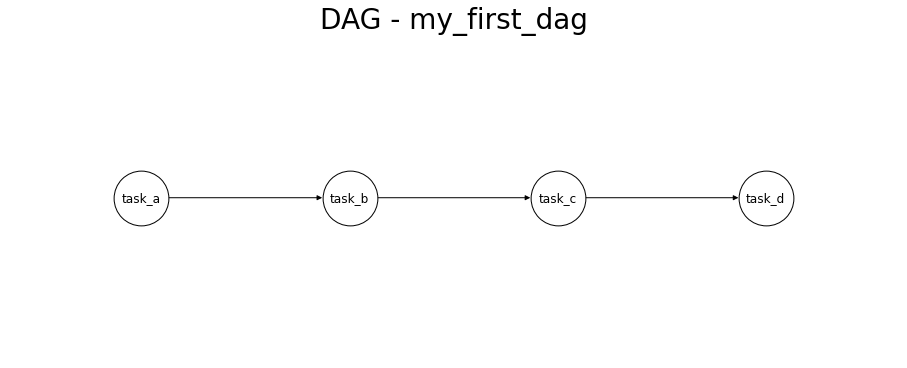

In [9]:
dag = DAG(name='my_first_dag')

a = Task(dag=dag, name='task_a', process=my_sleepy_code, process_kwargs={'text': 'Completed task A', 'sleep_time': 0})
b = Task(dag=dag, name='task_b', process=my_sleepy_code, process_kwargs={'text': 'Completed task B', 'sleep_time': 1})
c = Task(dag=dag, name='task_c', process=my_sleepy_code, process_kwargs={'text': 'Completed task C', 'sleep_time': 1})
d = Task(dag=dag, name='task_d', process=my_sleepy_code, process_kwargs={'text': 'Completed task D (last task, DAG run completed)', 'sleep_time': 1})

a >> b >> c >> d

print(dag)

In [10]:
dag.run_parallel()

Completed task A
Completed task B
Completed task C
Completed task D (last task, DAG run completed)


In [11]:
dag.tasks

{'root': [task_a],
 task_a: [task_b],
 task_b: [task_c],
 task_c: [task_d],
 task_d: []}

---

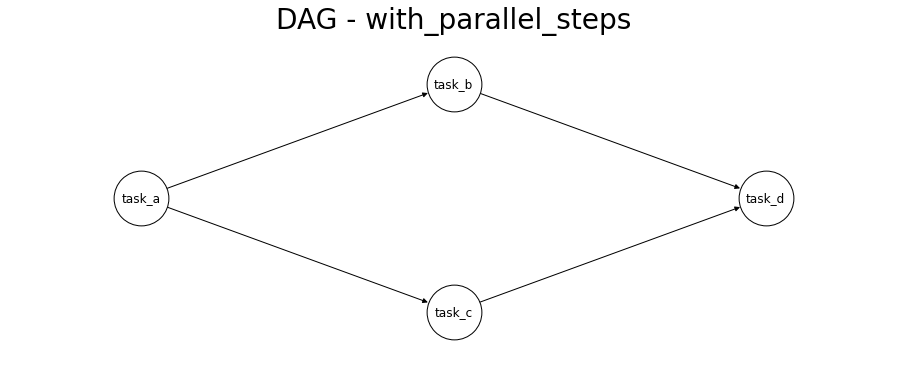

In [12]:
dag = DAG(name='with_parallel_steps')

a = Task(dag=dag, name='task_a', process=my_sleepy_code, process_kwargs={'text': 'Completed task A', 'sleep_time': 1})
b = Task(dag=dag, name='task_b', process=my_sleepy_code, process_kwargs={'text': 'Completed task B', 'sleep_time': 7})
c = Task(dag=dag, name='task_c', process=my_sleepy_code, process_kwargs={'text': 'Completed task C (I finish shortly after task B)', 'sleep_time': 8})
d = Task(dag=dag, name='task_d', process=my_sleepy_code, process_kwargs={'text': 'Completed task D', 'sleep_time': 3})

a >> b
a >> c
b >> d
c >> d

# a >> [b, c] >> d

print(dag)

In [13]:
dag.run_parallel()

Completed task A
Completed task B
Completed task C (I finish shortly after task B)
Completed task D


---

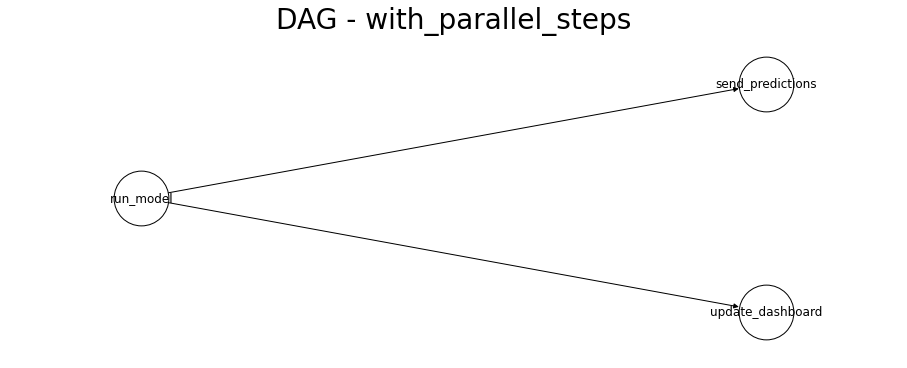

In [14]:
dag = DAG(name='with_parallel_steps')

run_model = Task(dag=dag, name='run_model', process=my_model, process_kwargs={'C': 1, 'kernel': 'rbf'})

send_predictions = Task(dag=dag, name='send_predictions', process=my_sleepy_code, process_kwargs={'text': 'send_predictions', 'sleep_time': 4})
update_dashboard = Task(dag=dag, name='update_dashboard', process=my_sleepy_code, process_kwargs={'text': 'update_dashboard (I finish shortly after sending predictions)', 'sleep_time': 5})


run_model >> [send_predictions, update_dashboard]

print(dag)

In [15]:
dag.run_parallel()

Predictions:
y_test: [1 1 1 0 0]
y_pred: [1 0 1 0 0]
accuracy_score: 0.8

send_predictions
update_dashboard (I finish shortly after sending predictions)


---

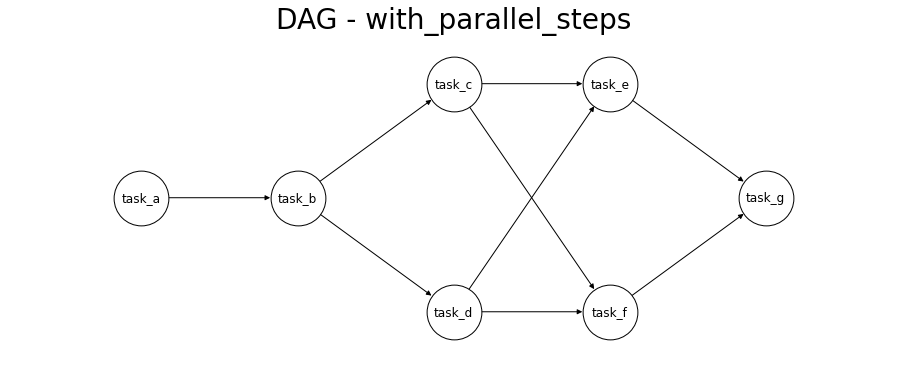

In [16]:
dag = DAG(name='with_parallel_steps')

a = Task(dag=dag, name='task_a', process=my_python_code)
b = Task(dag=dag, name='task_b', process=my_python_code)
c = Task(dag=dag, name='task_c', process=my_python_code)
d = Task(dag=dag, name='task_d', process=my_python_code)
e = Task(dag=dag, name='task_e', process=my_python_code)
f = Task(dag=dag, name='task_f', process=my_python_code)
g = Task(dag=dag, name='task_g', process=my_python_code)

a >> b >> [c,d] >> [e,f] >> g

print(dag)

---

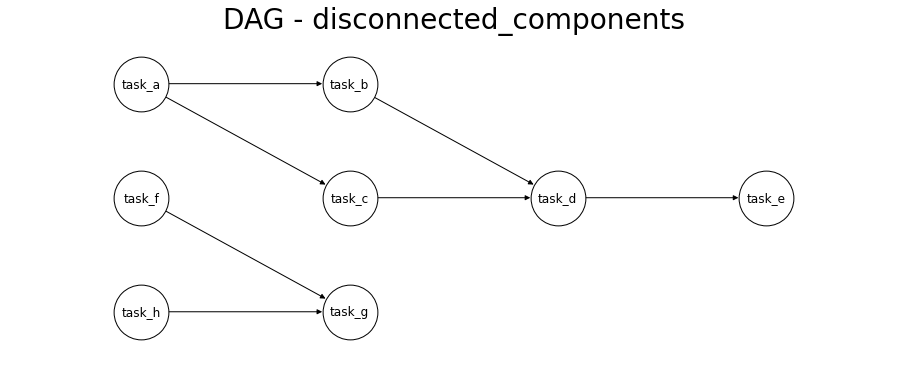

In [17]:
dag = DAG(name='disconnected_components')

a = Task(dag=dag, name='task_a', process=my_python_code)
b = Task(dag=dag, name='task_b', process=my_python_code)
c = Task(dag=dag, name='task_c', process=my_python_code)
d = Task(dag=dag, name='task_d', process=my_python_code)
e = Task(dag=dag, name='task_e', process=my_python_code)
f = Task(dag=dag, name='task_f', process=my_python_code)
g = Task(dag=dag, name='task_g', process=my_python_code)
h = Task(dag=dag, name='task_h', process=my_python_code)

a >> [b, c] >> d >> e
f >> g
h >> g

print(dag)

---

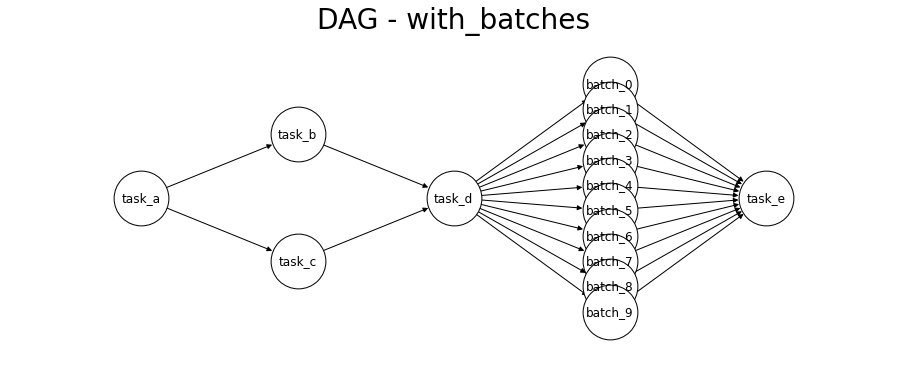

In [18]:
dag = DAG(name='with_batches')

a = Task(dag=dag, name='task_a', process=my_python_code)
b = Task(dag=dag, name='task_b', process=my_python_code)
c = Task(dag=dag, name='task_c', process=my_python_code)
d = Task(dag=dag, name='task_d', process=my_python_code)
e = Task(dag=dag, name='task_e', process=my_python_code)

a >> [b, c] >> d >> [Task(dag=dag, name=f'batch_{_}', process=my_python_code) for _ in range(10)] >> e

print(dag)

---

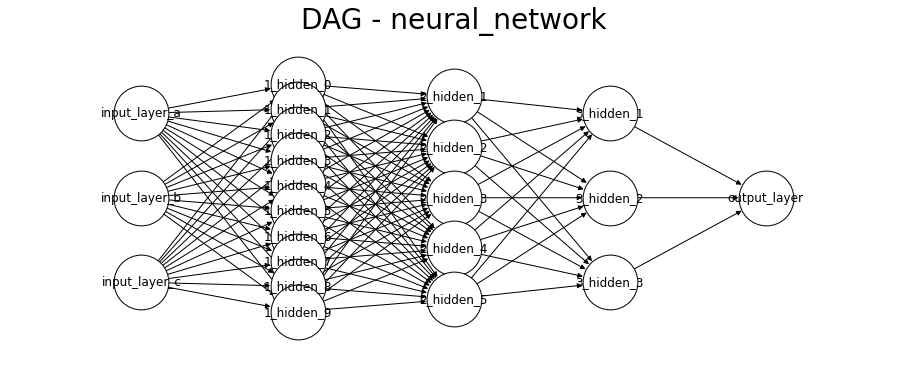

In [19]:
dag = DAG(name='neural_network')

input_a = Task(dag=dag, name='input_layer_a', process=my_python_code)
input_b = Task(dag=dag, name='input_layer_b', process=my_python_code)
input_c = Task(dag=dag, name='input_layer_c', process=my_python_code)

hidden_layer = [Task(dag=dag, name=f'1_hidden_{_}', process=my_python_code) for _ in range(10)]
hidden_layer_2 = [Task(dag=dag, name=f'2_hidden_{_}', process=my_python_code) for _ in range(1, 6)]
hidden_layer_3 = [Task(dag=dag, name=f'3_hidden_{_}', process=my_python_code) for _ in range(1, 4)]

output_layer = Task(dag=dag, name='output_layer', process=my_python_code)


input_a >> hidden_layer
input_b >> hidden_layer

input_c >> hidden_layer >> hidden_layer_2 >> hidden_layer_3

hidden_layer_3 >> output_layer

print(dag)

---